CNN for Fake News classification

# Importing general usage tools

In [2]:
from keras.models import Sequential
from keras import layers
from keras.layers import Convolution2D,Dense,MaxPooling2D,Flatten,LSTM,Bidirectional
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np

Using TensorFlow backend.


# Hyperparameter Adjustment

In [0]:
# parameter adjustments for fake news
maxlen = 100
max_features = 50000
train_glove = True   # Turn on/off for trainnable glove

# Reading in the dataset

In [0]:
# Reading files
import re
train = pd.read_csv("/content/drive/My Drive/cmpt400/dataset/train.csv")
valid = pd.read_csv("/content/drive/My Drive/cmpt400/dataset/valid.csv")
test = pd.read_csv("/content/drive/My Drive/cmpt400/dataset/test.csv")

train['news'] = train['news'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
valid['news'] = valid['news'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
test['news'] = test['news'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))

In [5]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train['news'])

# tokenize text 
X_train = tokenizer.texts_to_sequences(train['news'])
X_valid = tokenizer.texts_to_sequences(valid['news'])
X_test = tokenizer.texts_to_sequences(test['news'])

# turn categories into integer representation
y_train = pd.factorize(train['label'])[0]+1
y_valid = pd.factorize(valid['label'])[0]+1
y_test = pd.factorize(test['label'])[0]+1

#calculate the total vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# pad each news to maxlen
X_train = pad_sequences(X_train, maxlen=maxlen)
X_valid = pad_sequences(X_valid, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

n_timesteps, n_features = X_train.shape[0], X_train.shape[1]
print(n_timesteps)
print(n_features)

10240
100


# Plotting Graph Helper Function

In [0]:
# Plotting graph from results
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Read in glove file


In [0]:
def txt_create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [0]:
import numpy as np
from gensim.models import KeyedVectors
def bin_create_embedding_matrix(filepath,word_index,embedding_dim):
  vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
  # embedding_matrix = np.zeros((vocab_size, embedding_dim))
  # calculate how many word will be used
  num_words = min(max_features,vocab_size)
  # get a random matrix
  embedding_matrix = (np.random.rand(num_words, embedding_dim) - 0.5) / 5.0
  embeddings_index = KeyedVectors.load_word2vec_format(filepath, binary=True)

  for word, i in word_index.items():
    if i >= max_features: continue
    if word in embeddings_index:
      embeddings_vector = embeddings_index.get_vector(word)
      embedding_matrix[i] = embeddings_vector
  return embedding_matrix

In [9]:
#created the glove matrix
embedding_dim = 300
filepath_news = '/content/drive/My Drive/cmpt400/dataset/GoogleNews-vectors-negative300.bin'
filepath_6b = '/content/drive/My Drive/cmpt400/dataset/glove.6B.50d.txt'
embedding_matrix = bin_create_embedding_matrix(filepath_news,tokenizer.word_index, embedding_dim)
print(len(embedding_matrix))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


13402


In [10]:
# 93% coverage for the glove matrix, not bad
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)

1.0


# Creating Model


In [11]:
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.layers import Convolution2D,Dense,MaxPooling2D,Flatten,LSTM,Bidirectional,Dropout,CuDNNLSTM
from keras.losses import categorical_crossentropy
from keras.losses import sparse_categorical_crossentropy
train_glove = True

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,weights=[embedding_matrix], input_length=maxlen,trainable=train_glove))

# initialising the RNN
# number of units-memory units, complex problem requir more nerons.
# return sequence-mutiple LSM layers, set to True to receive values. Default value is False
# dimensions-it takes in count of original dataset. This case only include timestep and indicators.

# First LSTM layer
model.add(Bidirectional(CuDNNLSTM(units = 40,return_sequences = True, input_shape=(n_timesteps,n_features))))
model.add(Dropout(0.4))

# Second LSTM layer
model.add(Bidirectional(CuDNNLSTM(units = 40,return_sequences = True)))
model.add(Dropout(0.4))

# # Third LSTM layer
model.add(Bidirectional(CuDNNLSTM(units = 40,return_sequences = True)))
model.add(Dropout(0.4))

# Fourth LSTM layer, last layer no need to return, use default return sequence value false.
model.add(Bidirectional(CuDNNLSTM(units = 40)))
model.add(Dropout(0.4))

model.add(layers.Dense(7, activation='softmax'))
model.compile(optimizer=RMSprop(lr=0.001),loss=sparse_categorical_crossentropy,metrics=['accuracy'],)     # 0.001 seems to give the best output
model.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          4020600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 80)           109440    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 80)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 80)           39040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 80)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 80)           3904

# Predicting

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 10240 samples, validate on 1284 samples
Epoch 1/10
10240/10240 [==============================] - 13s 1ms/step - loss: 1.7784 - acc: 0.2062 - val_loss: 1.9980 - val_acc: 0.0981
Epoch 2/10
10240/10240 [==============================] - 6s 625us/step - loss: 1.6979 - acc: 0.2629 - val_loss: 2.0669 - val_acc: 0.1542
Epoch 3/10
10240/10240 [==============================] - 6s 623us/step - loss: 1.6003 - acc: 0.3256 - val_loss: 2.2635 - val_acc: 0.1254
Epoch 4/10
10240/10240 [==============================] - 6s 624us/step - loss: 1.4678 - acc: 0.4112 - val_loss: 2.3456 - val_acc: 0.1371
Epoch 5/10
10240/10240 [==============================] - 6s 622us/step - loss: 1.3265 - acc: 0.4878 - val_loss: 2.5395 - val_acc: 0.1184
Epoch 6/10
10240/10240 [==============================] - 6s 622us/step - loss: 1.1751 - acc: 0.5691 - val_loss: 2.7053 - val_acc: 0.1449
Epoch 7/10
10240/10240 [====

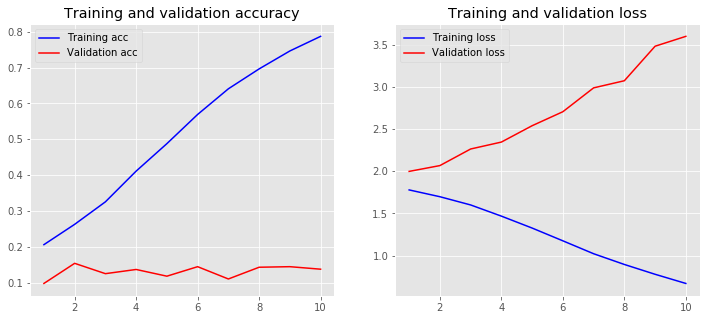

In [12]:
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_valid, y_valid),batch_size=64)
loss, accuracy = model.evaluate(X_train, y_train, verbose=2)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)